- 데이터 필터링은 charge session 단위가 아니라 'cid' 단위로 할것.
    - 동일 cid의 일부 charge session을 제외할 경우 시간순에 따라 windowing을 하여 피쳐를 생성하는 과정에서 왜곡이 발생함

In [1]:
import pandas as pd

pd.options.display.float_format = '{: .2f}'.format

## 1. Data Load & Filtering

In [2]:
# 가장 최근의 2021년 7월~ 12월 (6개월) 데이터 로드

df = pd.read_csv('../data/한국전력공사_전기차충전소충전량(202107_202112).csv', 
                 parse_dates=['충전종료일자', '충전시작시각', '충전종료시각'], 
                 encoding='cp949')

In [4]:
rename_dict = {'본부':'headquarter', '사업소':'office', '충전소명':'station_name', '충전기':'charger_name', 
               '충전기ID':'cid', '주소':'address', '충전기구분':'charger_type', '충전용량':'charging_power', 
               '충전량':'charge_amount', '충전시간':'hour', '충전분':'minute', '충전시작시각':'start_time', 
               '충전종료시각':'finish_time'}

df = df.rename(columns=rename_dict).drop(columns=['충전종료일자'])
df = df.loc[df['charger_type'] == '급속']
df['duration'] = df.hour.multiply(60).add(df.minute)
df = df.drop(['charger_type', 'hour', 'minute'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583023 entries, 1 to 1048572
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   headquarter     583023 non-null  object        
 1   office          583023 non-null  object        
 2   station_name    583023 non-null  object        
 3   charger_name    583023 non-null  object        
 4   cid             583023 non-null  int64         
 5   address         582745 non-null  object        
 6   charging_power  556320 non-null  float64       
 7   charge_amount   583023 non-null  float64       
 8   start_time      583023 non-null  datetime64[ns]
 9   finish_time     583023 non-null  datetime64[ns]
 10  duration        583023 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 53.4+ MB


In [6]:
# 8080개 device
df.cid.nunique()

8080

In [7]:
# 7~12월 간의 데이터이지만 실질적으로 10월 17일까지의 로그만 존재함
display(df.describe(datetime_is_numeric=True))

# 7~9의 3개월 데이터만 분리
df = df[df.start_time.between('2021-07-01', '2021-10-01')]
df.cid.nunique()

,cid,charging_power,charge_amount,start_time,finish_time,duration
count,583023.00,556320.00,583023.00,583023,583023,583023.00
mean,514164.77,60.65,35.20,2021-08-24 21:19:12.408174080,2021-08-24 22:12:10.731466752,52.48
min,1.00,20.00,0.00,2018-05-21 11:56:10,2021-07-01 00:00:03,-120016.00
25%,2050.00,50.00,13.11,2021-07-28 10:13:35.500000,2021-07-28 10:56:28.500000,24.00
50%,6172.00,50.00,23.40,2021-08-24 21:37:09,2021-08-24 22:33:01,40.00
75%,8847.00,50.00,37.27,2021-09-21 11:06:12.500000,2021-09-21 11:47:41,64.00
max,55000001.00,200.00,1113424.47,2022-01-01 01:51:38,2021-10-17 23:59:39,1780167.00
std,2364417.74,35.69,2957.37,NaN,NaN,2342.69


7723

In [8]:
# 실질적으로 활발히 운영되는 충전기로 한정하기 위하여, 분석기간(3개월) 내 첫주와 마지막주에 모두 충전시작이 있는 충전기로 제한

first_charge = df.groupby('cid')['start_time'].min()
valid_id_first = first_charge[first_charge < '2021-07-07'].index

last_charge = df.groupby('cid')['start_time'].max()
valid_id_last = last_charge[last_charge > '2021-09-23'].index

In [9]:
# 총 3,213개의 충전기
valid_cid = set(valid_id_first).intersection(valid_id_last)
len(valid_cid)

3213

In [10]:
# 총 충전의 90% 이상이며 3개월간 441,530건
df.cid.isin(valid_cid).mean(), df.cid.isin(valid_cid).sum()

(0.9060910215866905, 441530)

In [11]:
# valid_cid의 로그만 선택하여 charge 테이블 생성
charge = df[df.cid.isin(valid_cid)].copy()

In [12]:
charge.head()

,headquarter,office,station_name,charger_name,cid,address,charging_power,charge_amount,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01 07:14:24,2021-07-01 07:54:04,39


In [13]:
# charging_power에서 null 발생 ->  피쳐로 활용할 것 이므로 null row 제거
charge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441530 entries, 10 to 899545
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   headquarter     441530 non-null  object        
 1   office          441530 non-null  object        
 2   station_name    441530 non-null  object        
 3   charger_name    441530 non-null  object        
 4   cid             441530 non-null  int64         
 5   address         441422 non-null  object        
 6   charging_power  436187 non-null  float64       
 7   charge_amount   441530 non-null  float64       
 8   start_time      441530 non-null  datetime64[ns]
 9   finish_time     441530 non-null  datetime64[ns]
 10  duration        441530 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 40.4+ MB


In [14]:
power_null_ids = charge[charge.charging_power.isna()].cid.unique()
charge = charge[~charge.cid.isin(power_null_ids)]

In [15]:
charge.charging_power.unique()

array([ 50., 200., 100.])

### duration 이상치 필터링

In [16]:
charge.duration.describe()

count    436187.00
mean         51.09
std          83.39
min           0.00
25%          25.00
50%          42.00
75%          66.00
max       24369.00
Name: duration, dtype: float64

In [17]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(charge.duration)

(-208.18165142488976, 292.18165142488976)

In [18]:
# 292분 초과하는 경우 1,915건으로 전체 중 0.4% 가량
charge.duration.gt(outlier_bound(charge.duration)[1]).sum(), charge.duration.gt(outlier_bound(charge.duration)[1]).mean()

(1915, 0.004390318831143524)

In [19]:
outlier_cid = charge[charge.duration.gt(outlier_bound(charge.duration)[1])].cid.unique()

In [20]:
charge = charge[~charge.cid.isin(outlier_cid)]

In [21]:
# 2453개의 cid
charge.cid.nunique()

2453

count    2453.00
mean        1.58
std         1.84
min         0.03
25%         0.51
50%         1.03
75%         2.02
max        24.48
Name: station_name, dtype: float64

<AxesSubplot: ylabel='Frequency'>

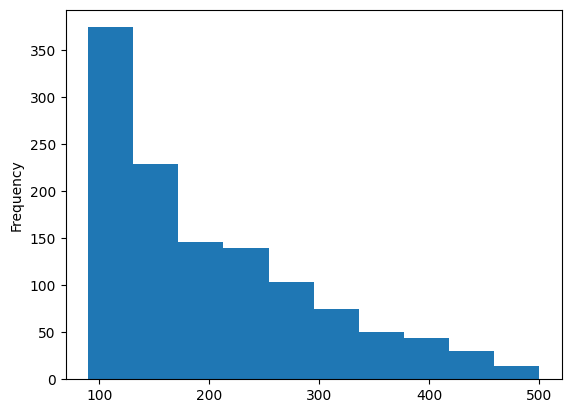

In [22]:
# 충전기당-일당 충전횟수는 최대 24.48회 최소 0.03회
display(charge.groupby('cid')['station_name'].count().divide(92).describe())

charge.groupby('cid')['station_name'].count().plot(kind='hist', range=(90,500))

In [23]:
# 충전소명으로 집계 가능 확인 ->  cid가 여러 충전소명 가지고있는 경우 없음
n_office = charge.groupby('cid')['station_name'].nunique()
n_office[n_office>1]

Series([], Name: station_name, dtype: int64)

In [24]:
charge.head()

,headquarter,office,station_name,charger_name,cid,address,charging_power,charge_amount,start_time,finish_time,duration
10,경기북부,양평,양평지사,급속02,8833,경기도 양평군 강상면 강남로 933,50.00,13.00,2021-07-01 11:19:00,2021-07-01 11:41:11,22
11,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,27.05,2021-07-01 07:26:01,2021-07-01 08:05:16,39
12,경남,창녕,창녕지사,급속01,471,"경상남도 창녕군 창녕읍 남창녕로 71 (교하리, 한국전력공사 창녕지점)",50.00,10.64,2021-07-01 13:56:30,2021-07-01 14:17:05,20
24,경북,문경,문경지사,급속01,792,경상북도 문경시 모전로 75,50.00,36.35,2021-07-01 01:50:09,2021-07-01 03:04:14,74
27,경기,경기직할,경기직할,급속02,879,경기도 수원시 팔달구 중부대로 120,50.00,7.69,2021-07-01 07:14:24,2021-07-01 07:54:04,39


<AxesSubplot: xlabel='charging_power', ylabel='duration'>

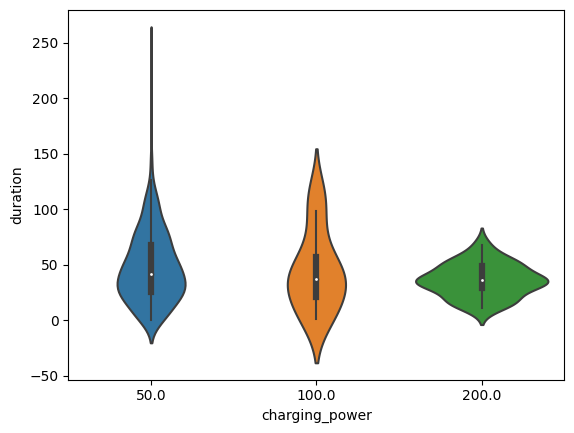

In [25]:
import seaborn as sns

data = charge.sample(frac=0.001)
sns.violinplot(data=data, x='charging_power', y='duration')

## 2. Window fucntion 적용
- 인풋 시퀀스 및 타겟 변수 생성

### start ->  finish 정보로 부터 step별 occupancy 여부 생성

#### 1) 특정 시점 점유 여부 (classification)

In [26]:
def extract_occupancy_cls(cid_df, start_date, end_date, interval_min):
    """transform charge log table to occupancy-by-window table for each charging station id

    Args:
        cid_df (pd.DataFrame): charging station log table of one charging stationID
        start_date (str): YYYY-MM-DD
        end_date (str): YYYY-MM-DD
        interval_min (int): window size (minute)

    Returns:
        pd.Series: Returns occupancy at each point in time index
    """
    n_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    time_idx = pd.date_range(start=start_date,
                             freq=f'{interval_min}min',
                             periods=n_days*24*60//interval_min)

    result = np.full(time_idx.shape[0], False)
    for start_time, finish_time in zip(cid_df.start_time, cid_df.finish_time):
        occupied = (time_idx >= start_time) & (time_idx <= finish_time)
        result = result | occupied
    return pd.Series(data=result, index=time_idx, dtype='Int32')

In [27]:
cid_sample = charge.query("cid == 8833")

extract_occupancy_cls(cid_df=cid_sample, start_date='2021-07-01', end_date='2021-09-30', interval_min=10)

2021-07-01 00:00:00    0
2021-07-01 00:10:00    0
2021-07-01 00:20:00    0
2021-07-01 00:30:00    0
2021-07-01 00:40:00    0
                      ..
2021-09-30 23:10:00    0
2021-09-30 23:20:00    0
2021-09-30 23:30:00    0
2021-09-30 23:40:00    0
2021-09-30 23:50:00    0
Freq: 10T, Length: 13248, dtype: Int32

#### 2) 구간 내 점유율 (regression)

In [28]:
def extract_occupancy_reg(cid_df, start_date, end_date, interval_min):
    """transform charge log table to occupancy-by-window table for each charging station id

    Args:
        cid_df (pd.DataFrame): charging station log table of one charging stationID
        start_date (str): YYYY-MM-DD
        end_date (str): YYYY-MM-DD
        interval_min (int): window size (minute)

    Returns:
        pd.Series: Returns the occupancy rate for each period
    """
    n_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    time_idx = pd.date_range(start=start_date, freq='1min', periods=n_days*24*60)
    
    start = pd.Series(index=cid_df.start_time, data=1, name='start').resample('1min').sum()
    assert start.le(1).all()
    finish = pd.Series(index=cid_df.finish_time, data=1, name='finish').resample('1min').sum()
    
    occupancy = pd.Series(index=time_idx, name='occupied', data=0).to_frame() \
        .join(start, how='left').join(finish, how='left')
    occupancy.start = occupancy.start.replace({1.:2.}).fillna(0)
    occupancy.finish = occupancy.finish.fillna(0)
    occupancy.occupied = occupancy.start.add(occupancy.finish).replace({0.:np.nan}).ffill().sub(1).fillna(0).astype('Int32')
    occupancy[occupancy.occupied.gt(1)] = 1
    
    return occupancy.resample(f'{interval_min}min').occupied.sum().divide(interval_min)


In [29]:
def extract_occupancy_reg(cid_df, start_date, end_date, interval_min):
    """transform charge log table to occupancy-by-window table for each charging station id

    Args:
        cid_df (pd.DataFrame): charging station log table of one charging stationID
        start_date (str): YYYY-MM-DD
        end_date (str): YYYY-MM-DD
        interval_min (int): window size (minute)

    Returns:
        pd.Series: Returns the occupancy rate for each period
    """
    n_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    time_idx = pd.date_range(start=start_date, freq='10S', periods=n_days*24*60*6)
    
    start = pd.Series(index=cid_df.start_time, data=1, name='start').resample('10S').sum()
    finish = pd.Series(index=cid_df.finish_time, data=1, name='finish').resample('10S').sum()
    
    occupancy = pd.Series(index=time_idx, name='occupied', data=0).to_frame() \
        .join(start, how='left').join(finish, how='left')
    occupancy.start = occupancy.start.replace({1.:2.}).fillna(0)
    occupancy.finish = occupancy.finish.fillna(0)
    occupancy.occupied = occupancy.start.add(occupancy.finish).replace({0.:np.nan}).ffill().sub(1).fillna(0).astype('Int32')
    occupancy[occupancy.occupied.gt(1)] = 1
    
    return occupancy.resample(f'{interval_min}min').occupied.sum().divide(interval_min*6)


In [30]:
occu_reg = extract_occupancy_reg(cid_df=cid_sample, start_date='2021-07-01', end_date='2021-09-30', interval_min=30)

### 적용예시

In [32]:
from tqdm import tqdm
tqdm.pandas()


occupancy_cls = charge.groupby('cid')[['start_time', 'finish_time']] \
                  .progress_apply(lambda df: extract_occupancy_cls(df, '2021-07-01', '2021-09-30', 10))

100%|██████████| 2453/2453 [01:04<00:00, 38.26it/s] 


In [33]:
occupancy_reg = charge.groupby('cid')[['start_time', 'finish_time']] \
                  .progress_apply(lambda df: extract_occupancy_reg(df, '2021-07-01', '2021-09-30', 30))

100%|██████████| 2453/2453 [10:10<00:00,  4.02it/s]


In [34]:
occupancy_cls.head()

,2021-07-01 00:00:00,2021-07-01 00:10:00,2021-07-01 00:20:00,2021-07-01 00:30:00,2021-07-01 00:40:00,2021-07-01 00:50:00,2021-07-01 01:00:00,2021-07-01 01:10:00,2021-07-01 01:20:00,2021-07-01 01:30:00,...,2021-09-30 22:20:00,2021-09-30 22:30:00,2021-09-30 22:40:00,2021-09-30 22:50:00,2021-09-30 23:00:00,2021-09-30 23:10:00,2021-09-30 23:20:00,2021-09-30 23:30:00,2021-09-30 23:40:00,2021-09-30 23:50:00
cid,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
occupancy_reg.head()

occupied,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
cid,,,,,,,,,,,,,,,,,,,,,
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.89,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.34,0.42,0.00,0.00,0.00,0.00,...,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
occupancy_reg = 1 - occupancy_reg

## 3. station단위 집계
- occupancy rate (regression) 기준, 동일 station 내 존재하는 기기의 occupancy rate를 각 window별로 평균
- window size가 모두 동일하게 때문에, micro/macro average 가 동일

In [42]:
## for classification
# station_history = occupancy_cls.reset_index() \
#                                .merge(charge[['cid', 'station_name']].drop_duplicates(), how='left', on='cid') \
#                                .drop(columns=['cid']) \
#                                .groupby('station_name').all().astype('Int32').T

In [43]:
history_by_st = occupancy_reg.reset_index() \
                                  .merge(charge[['cid', 'station_name']].drop_duplicates(), how='left', on='cid') \
                                  .drop(columns=['cid']) \
                                  .groupby('station_name').mean()

history_by_hq = occupancy_reg.reset_index() \
                             .merge(charge[['cid', 'headquarter']].drop_duplicates(), how='left', on='cid') \
                             .drop(columns=['cid']) \
                             .groupby('headquarter').mean()

In [44]:
history_by_st.head()

,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
station_name,,,,,,,,,,,,,,,,,,,,,
(주)플러스 전용 전기버스 충전소,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.79,1.00,1.00,1.00,1.00,0.54,0.00,0.08,0.75
2생활권 환승주차장1(A),1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.33,0.77
2호선 양산역,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
CGV 신대점,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
DMC아이파크 아파트,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [45]:
history_by_st

,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
station_name,,,,,,,,,,,,,,,,,,,,,
(주)플러스 전용 전기버스 충전소,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.79,1.00,1.00,1.00,1.00,0.54,0.00,0.08,0.75
2생활권 환승주차장1(A),1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.33,0.77
2호선 양산역,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
CGV 신대점,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
DMC아이파크 아파트,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
흑석한강센트레빌,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
흥덕힐스테이트 아파트,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.69,0.00,0.43,1.00,1.00,1.00,1.00,1.00
힐스테이트상도프레스티지,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [46]:
# 본부별 평균
display(history_by_hq.head())
history_by_hq.mean(axis=1).sort_values(ascending=False)

,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
headquarter,,,,,,,,,,,,,,,,,,,,,
강원,0.99,0.99,0.98,0.98,0.98,0.98,0.99,0.99,1.00,1.00,...,0.89,0.90,0.89,0.89,0.95,0.96,0.96,0.98,0.96,0.96
경기,0.99,0.98,0.97,0.98,0.99,0.99,0.99,1.00,1.00,1.00,...,0.92,0.91,0.92,0.92,0.91,0.93,0.95,0.95,0.95,0.96
경기북부,0.99,0.97,0.97,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,0.92,0.90,0.88,0.90,0.92,0.93,0.95,0.93,0.93,0.95
경남,0.98,0.98,0.98,0.99,0.99,0.99,0.99,0.99,0.99,1.00,...,0.93,0.92,0.90,0.89,0.92,0.96,0.96,0.96,0.96,0.96
경북,1.00,1.00,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,...,0.92,0.91,0.93,0.92,0.90,0.88,0.93,0.94,0.93,0.95


headquarter
특수        0.98
경북        0.96
경남        0.96
부산울산      0.96
경기        0.95
충북        0.95
경기북부      0.95
대전세종충남    0.95
대구        0.95
전북        0.95
인천        0.94
서울        0.94
본사        0.94
남서울       0.94
제주        0.94
강원        0.94
광주전남      0.94
dtype: float64

In [47]:
history_by_st.mean(axis=1).sort_values(ascending=False)[:int(len(history_by_st)*0.1)]

station_name
가락쌍용1차 아파트    1.00
시흥은행4차푸르지오    1.00
송파파인타운7단지     1.00
센텀동부센트레빌      1.00
동아한신아파트       1.00
              ... 
화성파크드림아파트     0.99
완주교육지원청       0.99
연희동성원아파트      0.99
반남국립박물관       0.99
신동백서해그랑블1차    0.99
Length: 209, dtype: float64

count    2095.00
mean        0.95
std         0.05
min         0.52
25%         0.93
50%         0.97
75%         0.98
max         1.00
dtype: float64

<AxesSubplot: ylabel='Frequency'>

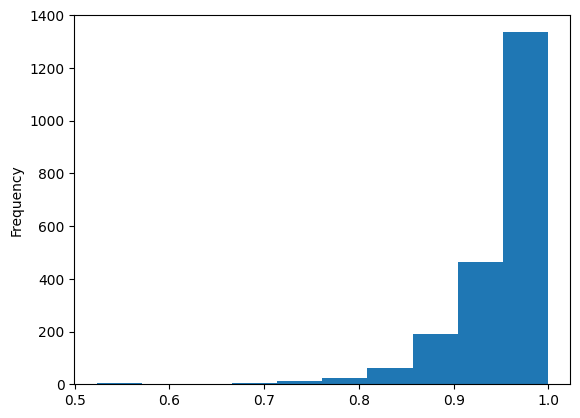

In [48]:
# 충전소의 평균 점유율
data = history_by_st.mean(axis=1)

display(data.describe())
data.plot(kind='hist')

count    209.00
mean       0.84
std        0.06
min        0.52
25%        0.82
50%        0.86
75%        0.88
max        0.89
dtype: float64

<AxesSubplot: ylabel='Frequency'>

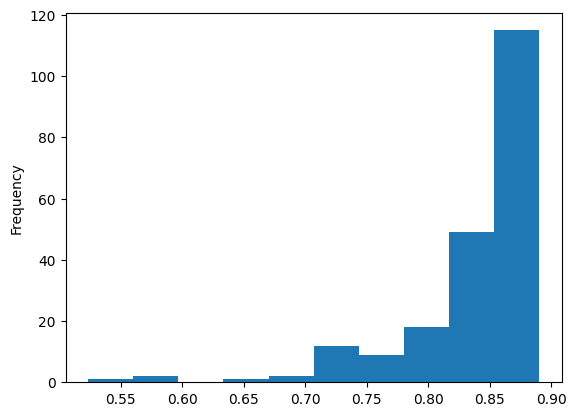

In [50]:
# 상위 10% 충전소의 평균 점유율
data = history_by_st.mean(axis=1).sort_values()[:int(len(history_by_st)*0.1)]

display(data.describe())
data.plot(kind='hist')

In [51]:
history_by_st.head()

,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
station_name,,,,,,,,,,,,,,,,,,,,,
(주)플러스 전용 전기버스 충전소,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.79,1.00,1.00,1.00,1.00,0.54,0.00,0.08,0.75
2생활권 환승주차장1(A),1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.33,0.77
2호선 양산역,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
CGV 신대점,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
DMC아이파크 아파트,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [52]:
history_by_st.shape

(2095, 4416)

In [53]:
history_by_st.T.reset_index().rename(columns={'index':'time'}).to_csv('../data/input_table/history_by_station.csv', index=False)

## 4. Station 부가정보 추가

In [54]:
import pandas as pd


station = pd.read_csv('../data/충전소위치_용도지역_도시지역.csv', usecols=['충전소명', 'A1'])
station.head()

,충전소명,A1
0,역삼래미안,15000001168020000000UQA01X0000002
1,현대까르띠에710아파트,15000001168020000000UQA01X0000002
2,열매마을5단지,63000003020020130251UQA1230001001
3,서진아파트,15000004812020030020UQA1239001001
4,팜스프링아파트,40600004148020080008UQA1300000002


In [55]:
station['A1'] = station['A1'].map(lambda x: x[20:26] if x is not np.nan else x)
station = station.rename(columns={'A1':'dcode', '충전소명':'station_name'})
station.head()

,station_name,dcode
0,역삼래미안,UQA01X
1,현대까르띠에710아파트,UQA01X
2,열매마을5단지,UQA123
3,서진아파트,UQA123
4,팜스프링아파트,UQA130


In [56]:
station_info = pd.DataFrame(data=history_by_st.index) \
    .merge(station.drop_duplicates(), how='left', on='station_name')

In [57]:
station_info

,station_name,dcode
0,(주)플러스 전용 전기버스 충전소,UQA430
1,2생활권 환승주차장1(A),UQA210
2,2호선 양산역,UQA430
3,CGV 신대점,UQA122
4,DMC아이파크 아파트,UQA01X
...,...,...
2102,흑석한강센트레빌,UQA122
2103,흥덕힐스테이트 아파트,UQA430
2104,힐스테이트상도프레스티지,UQA01X
2105,힐스테이트위례,NaN


In [58]:
station_info.dropna().to_csv('../data/input_table/station_info.csv', index=False)

## 5. Splitting Sequences

### 1) station 테이블 전처리

In [59]:
import pandas as pd

history = pd.read_csv('../data/input_table/history_by_station.csv', parse_dates=['time'])
station = pd.read_csv('../data/input_table/station_info.csv')


# replace_dic = {'제2종일반주거지역(7층)':'제2종일반주거지역(7층이하)', '제2종일반주거지역(12층)':'제2종일반주거지역(12층이하)', 
#                '2종(12층)일반주거지역':'제2종일반주거지역(12층이하)'}
# station.dgm_nm = station.dgm_nm.replace(replace_dic)

In [60]:
display(history.head())
display(station.head())

,time,(주)플러스 전용 전기버스 충전소,2생활권 환승주차장1(A),2호선 양산역,CGV 신대점,DMC아이파크 아파트,G-Tower(경제자유구역청),GS강동자이 아파트,HAPPY700 평창시네마,KBS 방송국,...,휘경베스트빌현대,휘경주공1단지,휴먼빌2단지 아파트,휴먼시아남춘천1단지,휴먼시아청계마을4단지,흑석한강센트레빌,흥덕힐스테이트 아파트,힐스테이트상도프레스티지,힐스테이트위례,힐스테이트황금산
0,2021-07-01 00:00:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,2021-07-01 00:30:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,2021-07-01 01:00:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,2021-07-01 01:30:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.63,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,2021-07-01 02:00:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,station_name,dcode
0,(주)플러스 전용 전기버스 충전소,UQA430
1,2생활권 환승주차장1(A),UQA210
2,2호선 양산역,UQA430
3,CGV 신대점,UQA122
4,DMC아이파크 아파트,UQA01X


### 2) history 테이블에 결합

In [61]:
data = history.set_index('time').T.reset_index().rename(columns={'index':'station_name'})
data = data[data.station_name.isin(station.station_name)].set_index('station_name')
data.head()

# .merge(station[['station_name', 'dgm_nm', 'gu']], how='left', on='station_name')

time,2021-07-01 00:00:00,2021-07-01 00:30:00,2021-07-01 01:00:00,2021-07-01 01:30:00,2021-07-01 02:00:00,2021-07-01 02:30:00,2021-07-01 03:00:00,2021-07-01 03:30:00,2021-07-01 04:00:00,2021-07-01 04:30:00,...,2021-09-30 19:00:00,2021-09-30 19:30:00,2021-09-30 20:00:00,2021-09-30 20:30:00,2021-09-30 21:00:00,2021-09-30 21:30:00,2021-09-30 22:00:00,2021-09-30 22:30:00,2021-09-30 23:00:00,2021-09-30 23:30:00
station_name,,,,,,,,,,,,,,,,,,,,,
(주)플러스 전용 전기버스 충전소,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,0.79,1.00,1.00,1.00,1.00,0.54,0.00,0.07,0.75
2생활권 환승주차장1(A),1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.33,0.77
2호선 양산역,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
CGV 신대점,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
DMC아이파크 아파트,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [62]:
data.mean(axis=1).describe()

count    1899.00
mean        0.95
std         0.05
min         0.52
25%         0.93
50%         0.97
75%         0.98
max         1.00
dtype: float64

In [64]:
data.mean(axis=1).le(0.9).sum()

250

<AxesSubplot: ylabel='Frequency'>

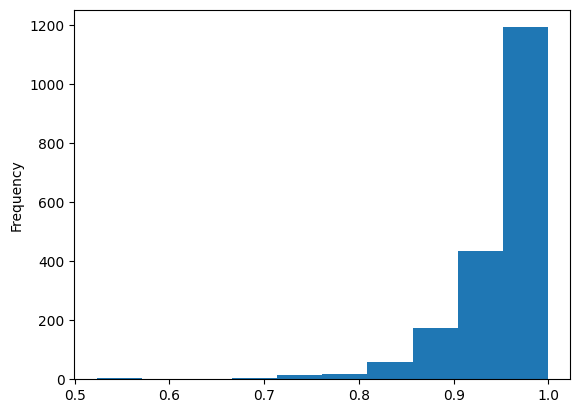

In [65]:
data.mean(axis=1).plot(kind='hist')

In [10]:
import numpy as np
from tqdm import tqdm

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	"""station should be in axis0 (index), timestamp should be axis1 (columns)

	Args:
		sequences (_type_): _description_
		n_steps_in (_type_): _description_
		n_steps_out (_type_): _description_

	Returns:
		_type_: _description_
	"""
	size = sequences.shape[1]
	xs = np.empty((0,n_steps_in))
	ys = np.empty((0,n_steps_out))

	for idx in tqdm(range(size - (n_steps_in + n_steps_out))):
		x = sequences[:,idx:idx+n_steps_in]
		xs = np.vstack([xs, x])
		y = sequences[:, idx+n_steps_in:idx+n_steps_in+n_steps_out]
		ys = np.vstack([ys, y])
	return xs, ys


def station_features(station_array, station_df, n_windows):
	df = pd.DataFrame(data=station_array, columns=['station_name']).merge(station_df[['station_name', 'gu', 'dgm_nm']], how='left', on='station_name')
	name_encoder = {name:idx for idx, name in enumerate(df.station_name.unique())}
	gu_encoder = {name:idx for idx, name in enumerate(df.gu.unique())}
	dgm_encoder = {name:idx for idx, name in enumerate(df.dgm_nm.unique())}

	df.station_name = df.station_name.map(name_encoder)
	df.gu = df.gu.map(gu_encoder)
	df.dgm_nm = df.dgm_nm.map(dgm_encoder)

	return np.tile(df.values, (n_windows,1))


def time_features(time_idx, n_steps_in, n_steps_out, n_stations):
	df = pd.DataFrame(data=pd.to_datetime(time_idx), columns=['time'])	
	df['seconds'] = df['time'].dt.hour.multiply(3600) + df['time'].dt.minute.multiply(60)
	seconds_in_day = 24*60*60
	df['sin_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.sin)
	df['cos_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.cos)
	df['dow'] = df['time'].dt.dayofweek
	df['weekend'] = df.dow.isin([5,6]).astype(np.int64)
	del df['seconds'], df['time']

	ts = np.empty((0,n_steps_out,4))
	for idx in tqdm(range(len(time_idx) - (n_steps_in + n_steps_out))):
		t = df.values[np.newaxis, idx+n_steps_in:idx+n_steps_in+n_steps_out, :]
		ts = np.vstack([ts, t])

	return np.repeat(ts, n_stations, axis=0)

In [11]:
N_STEPS_IN = 12
N_STEPS_OUT = 6

n_windows = data.shape[1] - (N_STEPS_IN + N_STEPS_OUT)
n_stations = data.shape[0]

S = station_features(station_array=data.index, station_df=station, n_windows=n_windows)
T = time_features(data.columns, 12, 6, 232)

X, Y = split_sequences(data.values, N_STEPS_IN, N_STEPS_OUT)

100%|██████████| 4398/4398 [02:52<00:00, 25.57it/s] 


- X: input sequence
- S: station features (category -> embedding)
- T: Time features (sin / cos / dow / weekend)
- Y: output sequence

In [19]:
X.shape, S.shape, T.shape, Y.shape

((1020336, 12), (1020336, 3), (1020336, 6, 4), (1020336, 6))

In [21]:
T.shape

(1020336, 6, 4)

## 6. time-context features

In [ ]:
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
contexts = pd.Series(data=TIME_IDX, name='ts').to_frame()

#### 1)  time encoding

In [ ]:
def add_time_features(df, dt_col):
    df['seconds'] = df[dt_col].dt.hour.multiply(3600) + df[dt_col].dt.minute.multiply(60)
    seconds_in_day = 24*60*60
    df['sin_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.sin)
    df['cos_time'] = df['seconds'].divide(seconds_in_day).multiply(2*np.pi).map(np.cos)

    df['dow'] = df[dt_col].dt.dayofweek
    df['weekend'] = df.dow.isin([5,6]).astype(np.int64)

    del df['seconds'], df[dt_col]
    return None



In [ ]:
TIME_IDX = pd.date_range('2021-07-01', freq='10min', periods=(31+31+30)*24*6)
contexts = pd.Series(data=TIME_IDX, name='ts').to_frame()

add_time_features(contexts, 'ts')

In [ ]:
contexts

,sin_time,cos_time,dow,weekend
0,0.00,1.00,3,0
1,0.04,1.00,3,0
2,0.09,1.00,3,0
3,0.13,0.99,3,0
4,0.17,0.98,3,0
...,...,...,...,...
13243,-0.22,0.98,3,0
13244,-0.17,0.98,3,0
13245,-0.13,0.99,3,0
13246,-0.09,1.00,3,0


In [ ]:
contexts.head()

,sin_time,cos_time,dow,weekend
0,0.00,1.00,3,0
1,0.04,1.00,3,0
2,0.09,1.00,3,0
3,0.13,0.99,3,0
4,0.17,0.98,3,0


<AxesSubplot: >

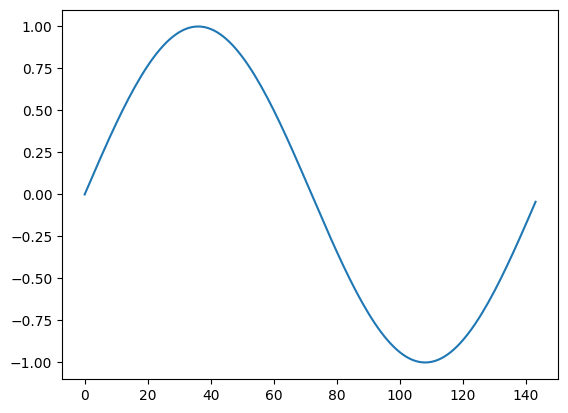

In [ ]:
contexts.iloc[:144].sin_time.plot()

<AxesSubplot: >

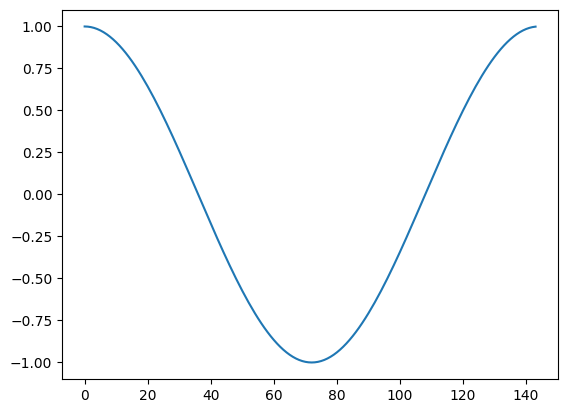

In [ ]:
contexts.iloc[:144].cos_time.plot()